# Forecast using RNNs & LSTMs

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import linregress

## Utilities

In [2]:
#mahaan hai tu , balwan hai tu, veerta ki misal hai chandragupta
def plot_graph(x, y, no_fit=False):
    plt.plot(x, y, 'b')

    if no_fit is False:
        fit = linregress(x, y)
        fit_line = fit.slope * x + fit.intercept
        plt.plot(x, fit_line, 'r', linestyle='--')

    plt.legend(['Graph', 'Fit line (Trend)'])
    plt.xlabel('Time')
    plt.ylabel('Graph')
    plt.grid(True)
    plt.show()

def multi_plot_graph(x, ys):
    for y in ys:
        plt.plot(x, y)

    plt.xlabel('Time')
    plt.ylabel('Graph')
    plt.grid(True)
    plt.show()

In [3]:
def Trend(time, slope):
    return time * slope

def Seasonality(time, period):
    time = (time % period) / period
    return np.where(time < 0.5, np.cos(2 * np.pi * time), 1 / np.exp(5 * time))

def Noise(time, amplitude):
    return amplitude * np.random.randn(len(time))

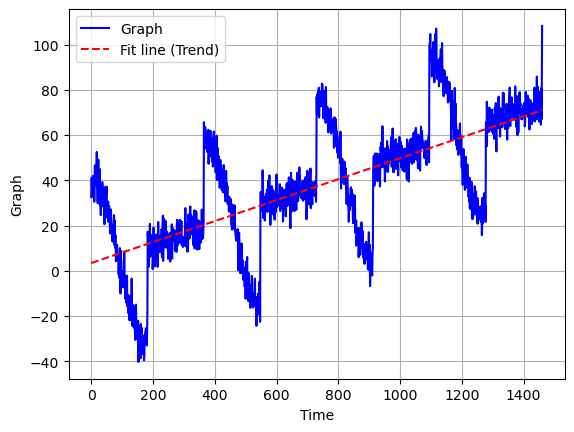

In [4]:
t = np.arange(0, 4 * 365 + 1, 1)
noise = 5 * Noise(t, 1)
signal = Trend(t, 0.05) + 40 * Seasonality(t, 365) + noise
plot_graph(t, signal)

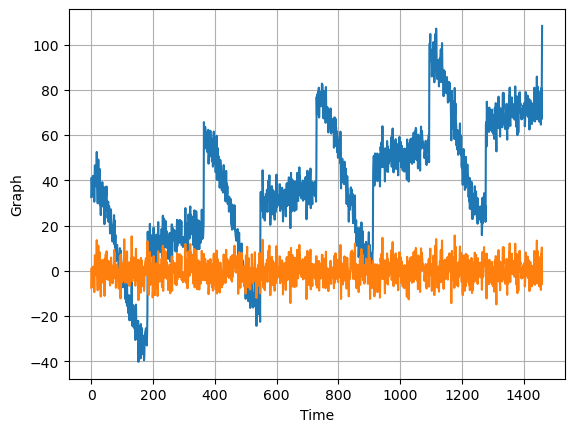

In [5]:
multi_plot_graph(t, (signal, noise))

Trying to remove trend & seasonality

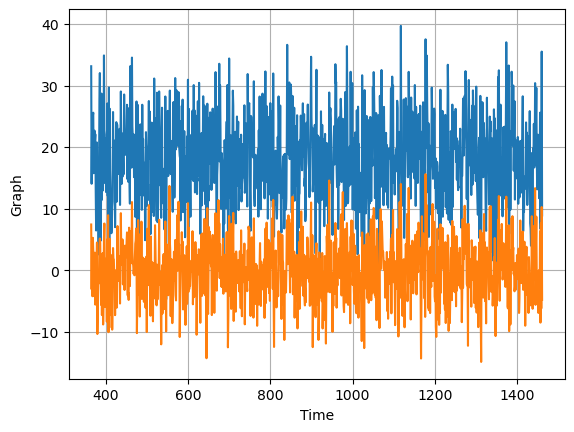

In [6]:
simple_signal = signal[365:] - signal[:-365]
multi_plot_graph(t[365:], (simple_signal, noise[365:]))

## Dataset Generation

In [7]:
SPLIT_TIME = 3 * 365
train_data = signal[:SPLIT_TIME]
train_time = t[:SPLIT_TIME]
valid_data = signal[SPLIT_TIME:]
valid_time = t[SPLIT_TIME:]

In [8]:
WINDOW_SIZE = 20
BATCH_SIZE = 32
EPOCHS = 100

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(train_data)
dataset = dataset.window(size=WINDOW_SIZE + 1, drop_remainder=True)

# This line batches the elements in each window into group of specified size & flattens the high dimensional (nested) dataset
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda x: (x[:-1], x[-1]))

dataset = dataset.shuffle(len(train_data))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [10]:
i = 0
for data in dataset.take(2):
    entri = [x.numpy() for x in data]
    print(len(entri))
    print(entri)
    i +=1
print(i)

2
[array([[  1.90605726,   6.0639568 ,  -5.42574974,  -1.97772019,
        -10.79191059, -13.47174531,  -0.97835783,  -8.20696293,
         -5.7975438 ,  -8.74025221,  -9.62324642, -16.44135863,
         -7.30381077, -13.35533618,  -9.15441502, -11.7850237 ,
         -2.28427678,  -5.90872796, -11.42727113, -15.82872598],
       [ 36.1982695 ,  36.86564522,  29.10502396,  31.75820665,
         35.84933653,  30.67055914,  34.09390055,  26.00240763,
         21.0267562 ,  31.07402689,  31.07258482,  28.49200242,
         21.3985065 ,  21.11133956,  33.28528411,  16.90397601,
         19.14541748,  19.68865209,  22.26741661,  11.04608663],
       [ 60.70868686,  63.16294246,  62.80505746,  55.65941953,
         49.1522878 ,  50.91122775,  48.78163617,  57.14691345,
         45.23661156,  60.11186437,  56.91904083,  53.16735466,
         47.93845386,  52.14951685,  53.68911603,  44.27786242,
         59.68837307,  59.46893187,  63.72303357,  54.06898586],
       [ 29.8419543 ,  36.79215966

## Model Creation

In [59]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Lambda

def create_model():
    model = Sequential([
        Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=(WINDOW_SIZE,)),
        SimpleRNN(40, return_sequences=True),
        SimpleRNN(40),
        Dense(1),
        Lambda(lambda x: x*100)
    ])
    return model 

model = create_model()

In [60]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

model.compile(
    optimizer=SGD(momentum=0.9),
    loss=Huber()
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_18 (Lambda)          (None, 20, 1)             0         
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 20, 40)            1680      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 40)                3240      
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                 
 lambda_19 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

## Model Training

In [62]:
hist_data = model.fit(dataset, epochs=EPOCHS, callbacks=[lr_scheduler])

Epoch 1/100
2/2 [==============================] - 1s 35ms/step - loss: 103.9075 - lr: 1.0000e-08
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 103.8291 - lr: 1.1220e-08
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 103.6768 - lr: 1.2589e-08
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 103.4441 - lr: 1.4125e-08
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 103.1444 - lr: 1.5849e-08
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 102.7667 - lr: 1.7783e-08
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 102.3088 - lr: 1.9953e-08
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 101.7834 - lr: 2.2387e-08
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 101.1424 - lr: 2.5119e-08
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 100.4460 - lr: 2.8184e-08
Epoch 11/100
2/2 [==========

## Plotting metrics

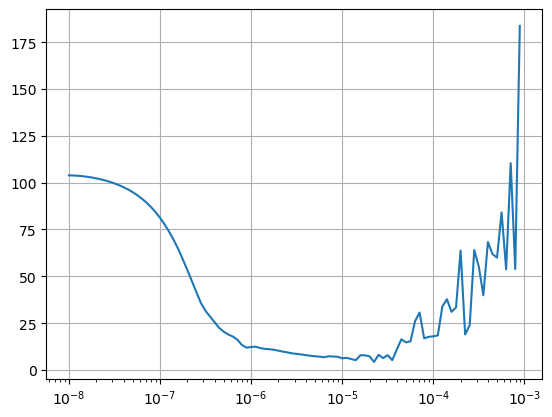

In [63]:
loss_data = hist_data.history['loss']
lrate =  1e-8 * (10 ** (np.arange(EPOCHS) / 20))

plt.semilogx(lrate, loss_data)
plt.grid(True)
plt.show()

The minimum loss and learning rate for that is given below

In [64]:
print('MINIMUM LOSS', np.min(loss_data))
print('LEARNING RATE', lrate[np.argmin(loss_data)])
min_loss = np.min(loss_data)
min_rate = lrate[np.argmin(loss_data)]

MINIMUM LOSS 4.300351142883301
LEARNING RATE 2.23872113856834e-05


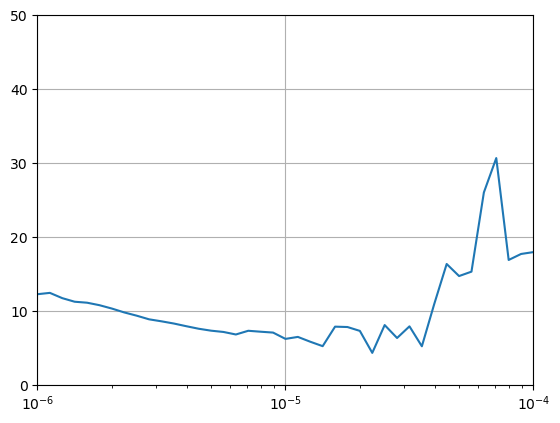

In [65]:
plt.semilogx(lrate, loss_data)
plt.grid(True)
plt.axis([1e-6, 1e-4, 0, 50])
plt.show()

# Training for that rate

In [66]:
model2 = create_model()
model2.compile(
    optimizer=SGD(learning_rate=min_rate, momentum=0.9),
    loss=Huber(),
    metrics=['mae']
)

In [67]:
hist_data2 = model2.fit(dataset, epochs=EPOCHS)

Epoch 1/100
2/2 [==============================] - 1s 37ms/step - loss: 45.0179 - mae: 45.5179
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 35.7540 - mae: 36.2446
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 18.8319 - mae: 19.3290
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 18.4027 - mae: 18.8940
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 27.2770 - mae: 27.7770
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 15.4741 - mae: 15.9735
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 19.3393 - mae: 19.8393
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 26.6640 - mae: 27.1640
Epoch 9/100
2/2 [==============================] - 0s 4ms/step - loss: 16.9731 - mae: 17.4574
Epoch 10/100
2/2 [==============================] - 0s 3ms/step - loss: 16.2629 - mae: 16.7577
Epoch 11/100
2/2 [==============================] - 0s 3ms

## Plotting metrics

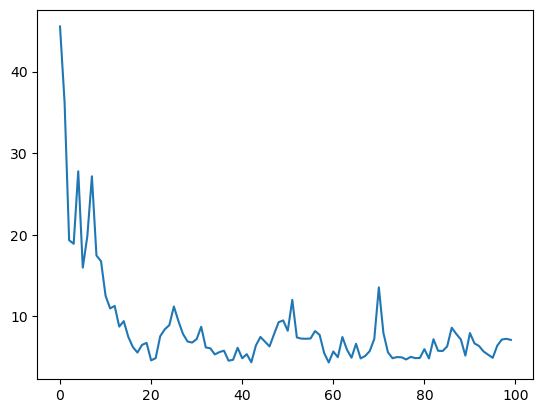

In [68]:
plt.plot(hist_data2.history['mae'])
plt.show()

## Forecast

Instead of rolling over windows sized over entire dataset, we will feed entire dataset into tensorflow batches

In [69]:
forecast_data = tf.data.Dataset.from_tensor_slices(signal[SPLIT_TIME-WINDOW_SIZE:-1])
forecast_data = forecast_data.window(size=WINDOW_SIZE, shift=1, drop_remainder=True)
forecast_data = forecast_data.flat_map(lambda w: w.batch(WINDOW_SIZE))
forecast_data = forecast_data.batch(BATCH_SIZE).prefetch(1)
forecast = model2.predict(forecast_data)
forecast = forecast.squeeze()

12/12 [==============================] - 0s 3ms/step


In [70]:
print(forecast)
print(forecast.shape)

[63.287758 68.400505 73.38818  73.744095 76.0843   74.930695 74.73686
 73.93227  73.33017  72.7769   73.02683  73.63724  73.64182  73.48126
 74.154076 74.164566 73.64958  72.726006 72.85937  73.50254  74.06569
 73.87447  73.258995 74.52283  74.04034  72.93559  73.29044  72.76371
 73.21199  73.47475  73.43787  73.12298  72.42731  73.00409  73.35482
 73.498245 73.53367  73.567276 74.03403  72.768295 72.58727  73.41936
 73.89008  73.355446 72.95488  72.86721  73.022285 71.824326 72.64466
 72.751175 72.34638  73.21945  72.84925  72.10733  72.26655  72.568436
 71.98447  72.515015 72.91785  72.02185  72.29994  71.4981   71.93275
 72.5924   71.709595 71.569214 72.38264  72.242615 71.740166 71.462616
 71.46509  70.2535   67.140915 67.508125 70.28592  69.61472  69.78086
 71.327225 70.19843  69.678635 68.651405 68.101555 66.830734 69.373116
 70.195984 69.59121  71.445816 69.82595  68.78034  66.228905 65.821365
 64.51107  63.939095 66.28134  63.824497 65.06024  65.10633  63.319565
 65.0624   65.7

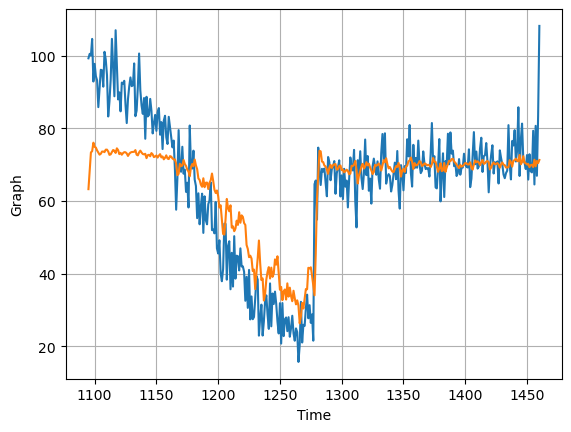

In [72]:
multi_plot_graph(valid_time, (valid_data, forecast))

In [73]:
print(tf.keras.metrics.mean_squared_error(valid_data, forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_data, forecast).numpy())

117.59557
8.122713


Axis

In [92]:
arr =  np.array([[[1,2,3],[4,5,6],[7,8,9]]])

sum1 = np.sum(arr, axis=0)
sum2 = np.sum(arr, axis=1)
sum3 = np.sum(arr, axis=2)
sum4 = np.sum(arr, axis=-1)

print('ARR', arr, arr.shape)
print('SUM1', sum1, sum1.shape)
print('SUM along rows', sum2, sum2.shape)
print('SUM along columns', sum3, sum3.shape)
print('SUM4', sum4, sum4.shape)

print('''
Axis=1
Sum over rows means we iterate over rows keeping column same.
SUM along rows = col0:[1+4+7], col1:[2+5+8], col2:[3+6+9]

Axis=2 or Axis=-1 in this case
Sum over cols means we iterate over cols keeping row same.
SUM along rows = row0:[1+2+3], row1:[4+5+6], row2:[7+8+9]
''')

ARR [[[1 2 3]
  [4 5 6]
  [7 8 9]]] (1, 3, 3)
SUM1 [[1 2 3]
 [4 5 6]
 [7 8 9]] (3, 3)
SUM along rows [[12 15 18]] (1, 3)
SUM along columns [[ 6 15 24]] (1, 3)
SUM4 [[ 6 15 24]] (1, 3)

Axis=1
Sum over rows means we iterate over rows keeping column same.
SUM along rows = col0:[1+4+7], col1:[2+5+8], col2:[3+6+9]

Axis=2 or Axis=-1 in this case
Sum over cols means we iterate over cols keeping row same.
SUM along rows = row0:[1+2+3], row1:[4+5+6], row2:[7+8+9]



Expand dims

In [93]:
print(arr)
arr = arr.squeeze()
print(arr)

[[[1 2 3]
  [4 5 6]
  [7 8 9]]]
[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [100]:
arr =  np.array([[1,2,3],[4,5,6],[7,8,9]])
print(arr,arr.shape)

arr2 = np.expand_dims(arr, axis=-1)
print(arr2, arr2.shape)

arr3 = np.expand_dims(arr, axis=0)
print(arr3, arr3.shape)

arr4 = np.expand_dims(arr, axis=1)
print(arr4, arr4.shape)

print('''
    Axis defines the index where new dimension is to be added
    in current dimension ie, index in tuple of shape
      
    For eg: org_shape = (3,3)
      axis = 0 => new axis should be added at org_shape[0]
      ie, new _shape=(1,3,3)

      axis = -1 => new axis should be added at org_shape[-1]
      ie, new _shape=(3,3,1)
      
''')

[[1 2 3]
 [4 5 6]
 [7 8 9]] (3, 3)
[[[1]
  [2]
  [3]]

 [[4]
  [5]
  [6]]

 [[7]
  [8]
  [9]]] (3, 3, 1)
[[[1 2 3]
  [4 5 6]
  [7 8 9]]] (1, 3, 3)
[[[1 2 3]]

 [[4 5 6]]

 [[7 8 9]]] (3, 1, 3)

    Axis defines the index where new dimension is to be added
    in current dimension ie, index in tuple of shape
      
    For eg: org_shape = (3,3)
      axis = 0 => new axis should be added at org_shape[0]
      ie, new _shape=(1,3,3)

      axis = -1 => new axis should be added at org_shape[-1]
      ie, new _shape=(3,3,1)
      

